In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
from jax.config import config
config.update("jax_enable_x64", True)

import morphine
import morphine_model
import pysynphot as S

import scipy
import scipy.ndimage as ndimage
from scipy.ndimage import zoom

import warnings
warnings.filterwarnings("ignore")


In [2]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 2000
pdiam2 = 0.13
osamp = 2

In [3]:
##################
# Define TOLIMAN #
# wavelength and #
# spectra info   #
##################

n_wavs = 100
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = np.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia for alpha cen A
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

In [4]:
#############################
# Stuff to get the optical  #
# system to work            #
#############################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

def get_toliman_pupil(size, file = 'Toliman_pupil.npy',path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load(file)
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [5]:
def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/np.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))


def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)

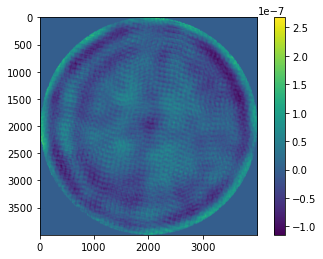

In [6]:
phaseMap = np.load('phaseMap_nm.npy')
plt.imshow(phaseMap)
plt.colorbar()


In [7]:
#######################################
# Define secondary mirror obscuration #
#######################################

trans = np.zeros((num_pix*osamp,num_pix*osamp))
y, x = np.indices((num_pix*osamp, num_pix*osamp))
r = np.sqrt((x-num_pix*osamp/2)**2 + (y-num_pix*osamp/2)**2)
trans[r<2000] = 1

secondary = morphine.InverseTransmission(morphine.CircularAperture(radius = 0.0071))
primary = morphine.CircularAperture( radius=0.13/2)


In [8]:
#######################################
# Define secondary mirror OPD effects #
#######################################


complex_optic = morphine.ArrayOpticalElement(transmission=trans,
                                          opd=phaseMap,
                                          name='Secondary Mirror')

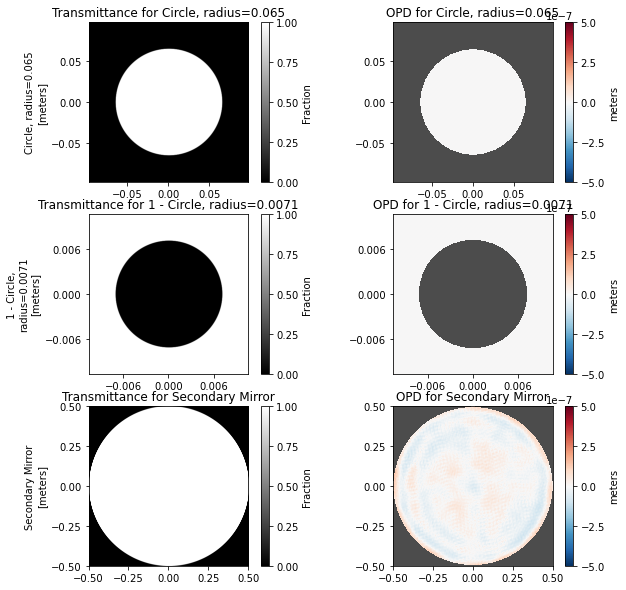

In [9]:
##################
# Create Optical #
# System         #
##################

optsys = morphine.OpticalSystem()
optsys.add_pupil(primary)
optsys.add_pupil(secondary)
optsys.add_pupil(complex_optic)
optsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 

plt.figure(figsize = (10,10))
optsys.display(what = 'both')

In [10]:
image_dirty = get_bb_psf(0,0,optsys, wavs, weights = weights_A)

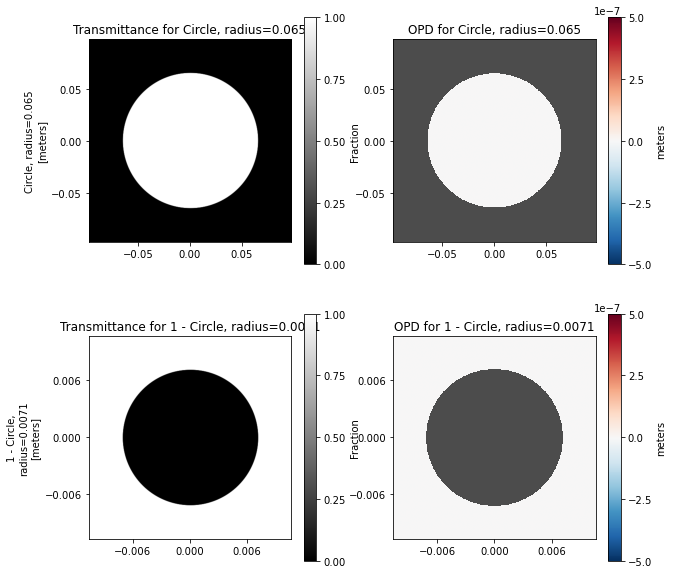

In [11]:
##################
# Create Optical #
# System         #
##################

optsys_clean = morphine.OpticalSystem()
optsys_clean.add_pupil(primary)
optsys_clean.add_pupil(secondary)
optsys_clean.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 

plt.figure(figsize = (10,10))
optsys_clean.display(what = 'both')

In [12]:
image_clean = get_bb_psf(0,0,optsys_clean, wavs, weights = weights_A)

In [13]:
residual = image_dirty - image_clean

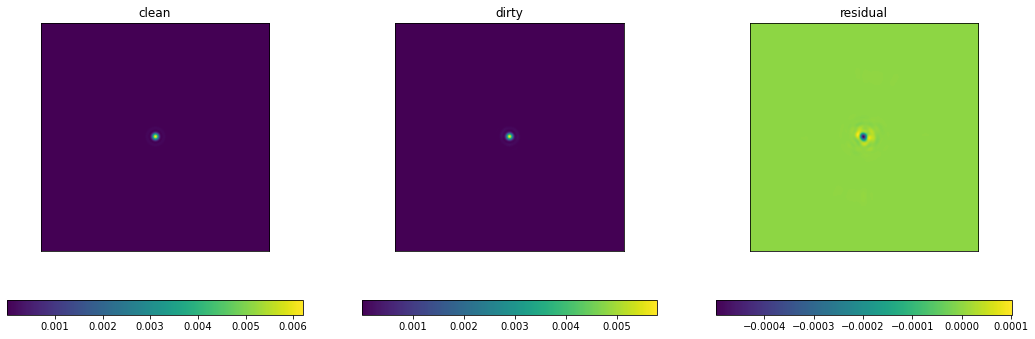

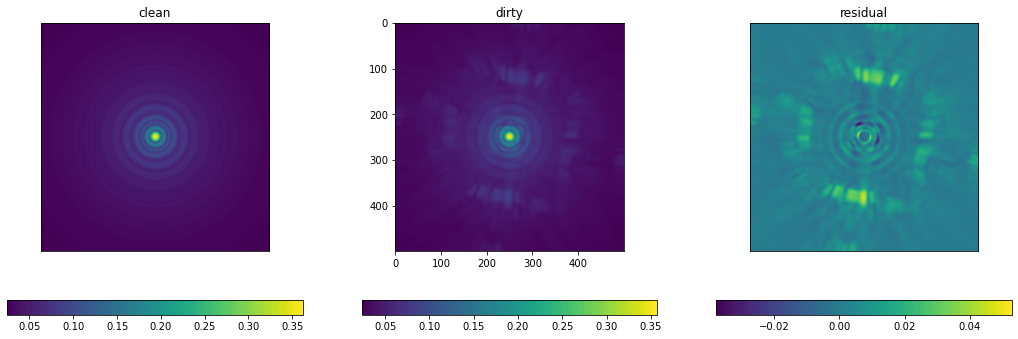

In [14]:
plt.figure(figsize = (18,6))

plt.subplot(1,3,1)
plt.imshow(image_clean[750:1250,750:1250])
plt.title('clean')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(image_dirty[750:1250,750:1250])
plt.title('dirty')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow(residual[750:1250,750:1250])
plt.title('residual')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')

plt.figure(figsize = (18,6))

plt.subplot(1,3,1)
plt.imshow(image_clean[750:1250,750:1250]**0.2)
plt.title('clean')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(image_dirty[750:1250,750:1250]**0.2)
plt.title('dirty')
#plt.xticks([])
#plt.yticks([])
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow((image_dirty**0.2 - image_clean**0.2)[750:1250,750:1250])
plt.title('residual')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation = 'horizontal')

In [15]:
image_dirty_norm = image_dirty/np.max(image_dirty)
image_clean_norm = image_clean/np.max(image_clean)


In [16]:
# think this is correct
print(np.max(image_dirty))
print(np.max(image_clean))

max_ratio = np.max(image_dirty)/np.max(image_clean)
print(max_ratio)

dirty_no_airy = image_dirty - max_ratio * image_clean
str_dirty_no_airy = image_dirty**0.2 - (max_ratio * image_clean)**0.2
#print(np.min(dirty_no_airy))
#dirty_no_airy_pos = dirty_no_airy + np.abs(np.min(dirty_no_airy))

0.005796126402254992
0.006197738065836078
0.9352002844723466


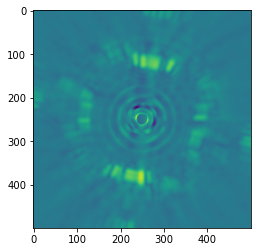

In [17]:
plt.imshow(str_dirty_no_airy[750:1250,750:1250])

## TODo:
- see if I can remove the airy pattern
- make plots of sidelobe pattern and intensity
- note that this isn't alinged with diagonals so depending on rotation of seconday mirror this shouldn't be a problem

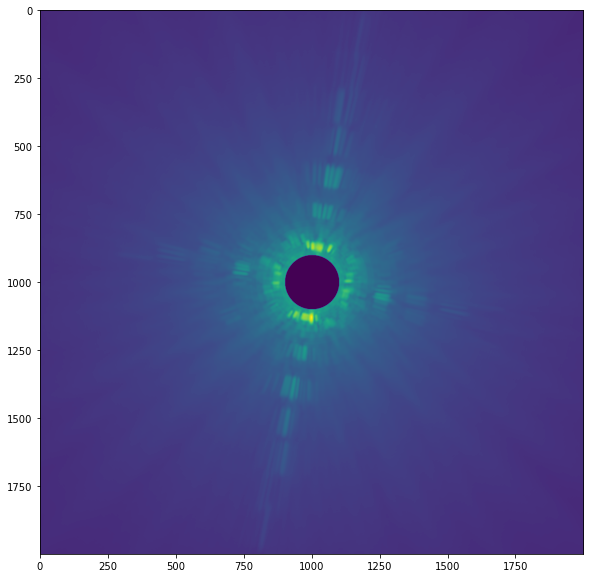

In [73]:
mask = np.ones((num_pix,num_pix))
y, x = np.indices((num_pix, num_pix))
r = np.sqrt((x-num_pix/2)**2 + (y-num_pix/2)**2)
mask[r<100] = 0

plt.figure(figsize = (10,10))
plt.imshow((mask*image_dirty)**0.2)


In [80]:
masked_dirty = mask*image_dirty
masked_clean = mask*image_clean
print(np.sum(masked_dirty)) #~4% of light in the sidelobes
print(np.sum(image_dirty))

0.03909284041634288
1.0000000000000007


In [20]:
def annulus(radius, thickness):
    mask = np.zeros((num_pix,num_pix))
    y, x = np.indices((num_pix, num_pix))
    r = np.sqrt((x-num_pix/2)**2 + (y-num_pix/2)**2)
    mask[r<radius+thickness] = 1
    mask[r<radius] = 0
    return mask

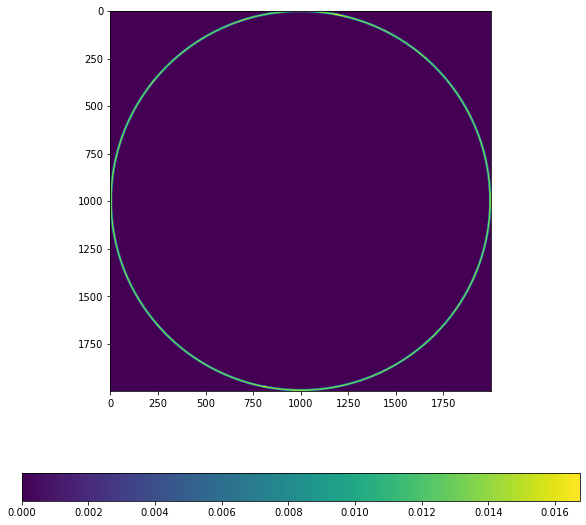

In [21]:
mask = annulus(990,10)
plt.figure(figsize = (10,10))

plt.imshow((mask*image_dirty)**0.2)
plt.colorbar(orientation = 'horizontal')

In [22]:
%%time
#innerR = np.linspace(0,99,991)*10
innerR = np.linspace(0,999,1000)
print(innerR[:10])

intensity_dirty = []
intensity_clean = []

for R in innerR:
    mask = annulus(R, thickness = 1)
    ring = mask*image_dirty
    intensity = np.sum(ring)
    intensity_dirty = np.append(intensity_dirty, intensity)
    
for R in innerR:
    mask = annulus(R, thickness = 1)
    ring = mask*image_clean
    intensity = np.sum(ring)
    intensity_clean = np.append(intensity_clean, intensity)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
CPU times: user 2min 15s, sys: 47.1 s, total: 3min 2s
Wall time: 2min 39s


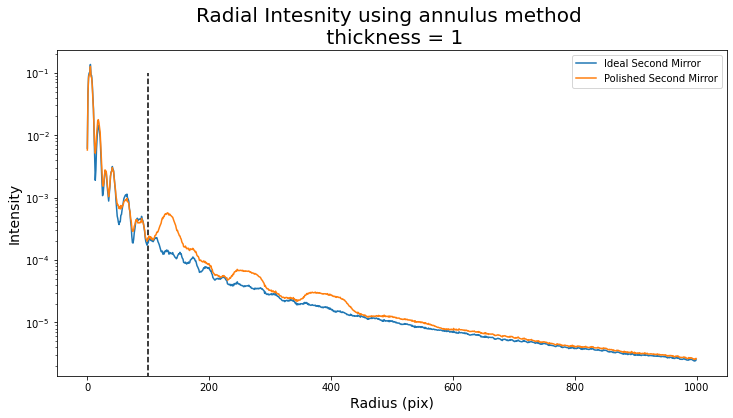

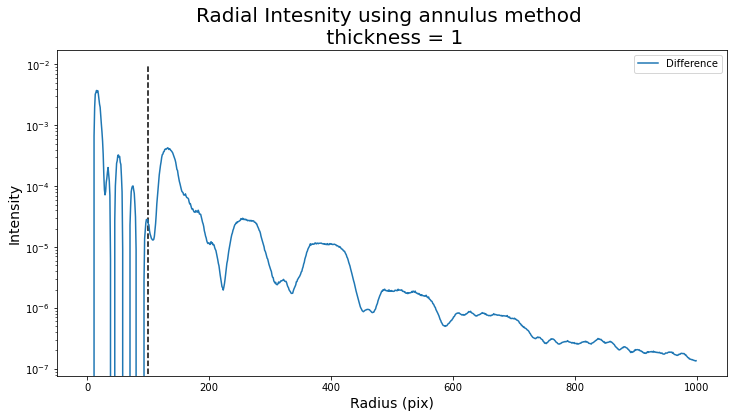

In [33]:
plt.figure(figsize = (12,6))

plt.plot(intensity_clean, label = 'Ideal Second Mirror')
plt.plot(intensity_dirty, label = 'Polished Second Mirror')
plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using annulus method \n thickness = 1', fontsize = 20)
plt.vlines(100, 0, 0.1, ls= '--', color = 'black')
plt.legend()

plt.figure(figsize = (12,6))

plt.plot(intensity_dirty - intensity_clean, label = 'Difference')
plt.vlines(100, 0, 0.01, ls= '--', color = 'black')
plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using annulus method \n thickness = 1', fontsize = 20)
plt.legend()

In [93]:
%%time
innerR = np.linspace(0,99,991)*10
#innerR = np.linspace(0,999,1000)
print(innerR[:10])

intensity_dirty2 = []
intensity_clean2 = []

count = 0
for R in innerR:
    mask = annulus(R, thickness = 10)
    ring = mask*image_dirty
    intensity = np.sum(ring)
    intensity_dirty2 = np.append(intensity_dirty2, intensity)
    if count % 10 == 0:
        np.save('Images/Annulus/Thickness10/annulus{}'.format(int(R)), ring)
    count +=1
    
for R in innerR:
    mask = annulus(R, thickness = 10)
    ring = mask*image_clean
    intensity = np.sum(ring)
    intensity_clean2 = np.append(intensity_clean2, intensity)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
CPU times: user 2min 24s, sys: 22.2 s, total: 2min 46s
Wall time: 2min 55s


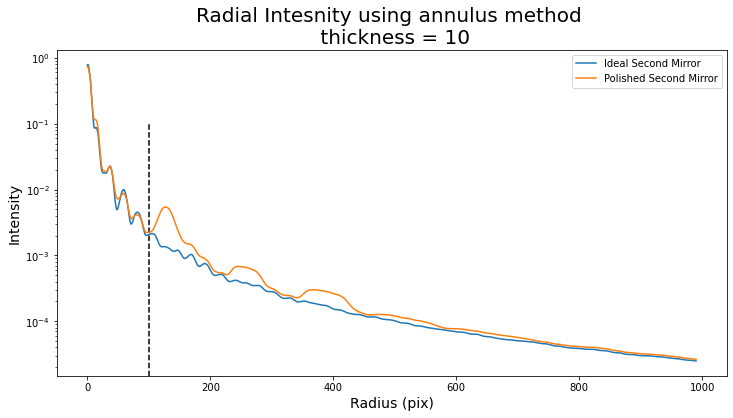

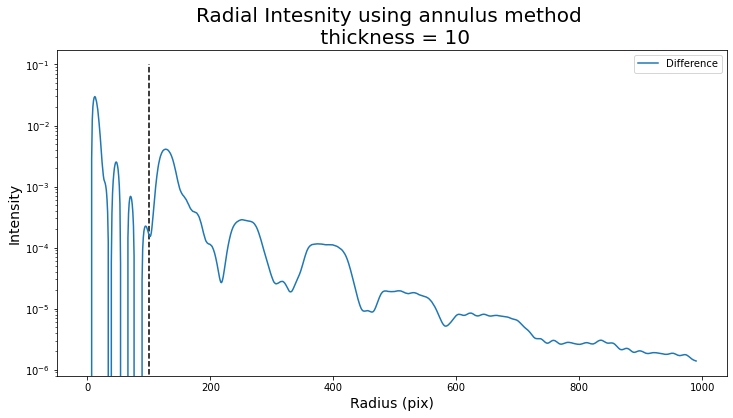

In [31]:
plt.figure(figsize = (12,6))

plt.plot(intensity_clean2, label = 'Ideal Second Mirror')
plt.plot(intensity_dirty2, label = 'Polished Second Mirror')
plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using annulus method \n thickness = 10', fontsize = 20)
plt.vlines(100, 0, 0.1, ls= '--', color = 'black')
plt.legend()

plt.figure(figsize = (12,6))

plt.plot(intensity_dirty2 - intensity_clean2, label = 'Difference')
plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using annulus method \n thickness = 10', fontsize = 20)
plt.vlines(100, 0, 0.1, ls= '--', color = 'black')
plt.legend()

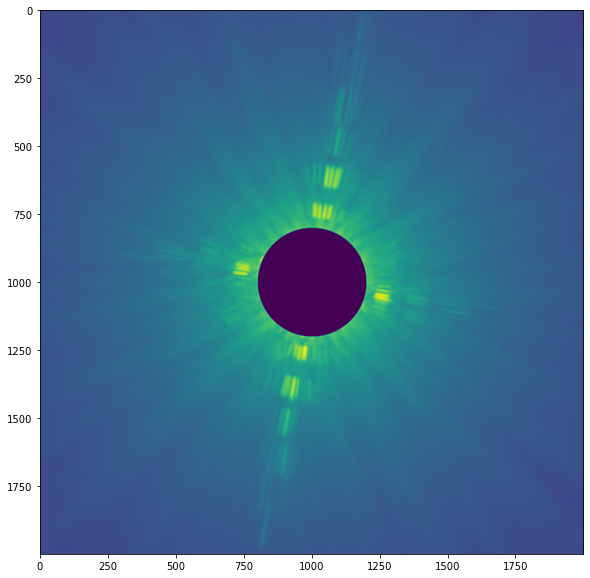

In [86]:
mask = np.ones((num_pix,num_pix))
y, x = np.indices((num_pix, num_pix))
r = np.sqrt((x-num_pix/2)**2 + (y-num_pix/2)**2)
mask[r<200] = 0

larger_masked_dirty = mask*image_dirty
larger_masked_clean = mask*image_clean

plt.figure(figsize = (10,10))
plt.imshow(larger_masked_dirty**0.2)

In [53]:
# stolen from https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)
    return circmask*anglemask


<class 'numpy.ndarray'>


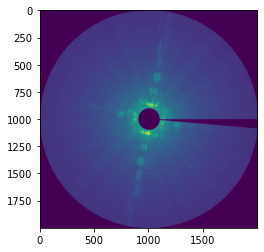

In [75]:
sector = sector_mask((2000,2000), (1000,1000), 1000, (5,360))
test = masked_dirty
#plt.imshow(masked_dirty)
test = test*sector
plt.imshow(test**0.2)

print(type(sector))
#plt.imshow(sector)

In [87]:
%%time

degs = np.linspace(0,359, 360) + 50

intensity_clean_radial = []
intensity_dirty_radial = []

for deg in degs:
    sector = sector_mask((2000,2000), (1000,1000), 1000, (deg,deg+1))
    the_slice = sector*masked_dirty
    intensity = np.sum(the_slice)
    intensity_dirty_radial = np.append(intensity_dirty_radial, intensity)
    
for deg in degs:
    sector = sector_mask((2000,2000), (1000,1000), 1000, (deg,deg+1))
    the_slice = sector*masked_clean
    intensity = np.sum(the_slice)
    intensity_clean_radial = np.append(intensity_clean_radial, intensity)

CPU times: user 2min 14s, sys: 1.11 s, total: 2min 15s
Wall time: 2min 7s


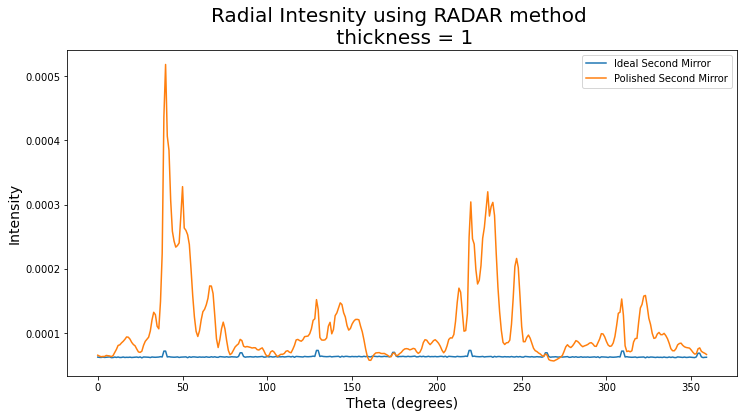

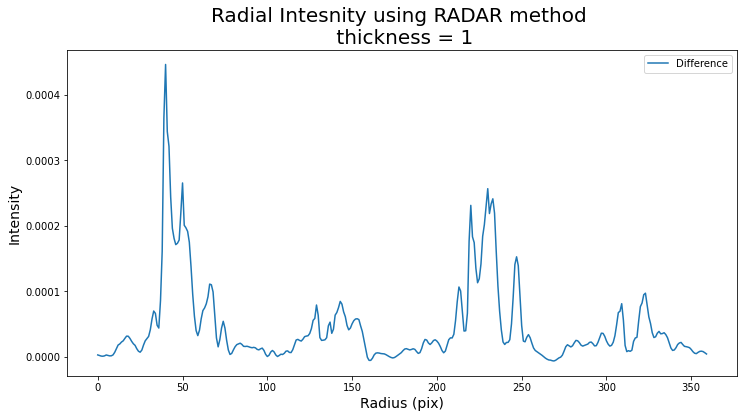

In [88]:
plt.figure(figsize = (12,6))

plt.plot(intensity_clean_radial, label = 'Ideal Second Mirror')
plt.plot(intensity_dirty_radial, label = 'Polished Second Mirror')
#plt.yscale('log')
plt.xlabel('Theta (degrees)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using RADAR method \n thickness = 1', fontsize = 20)
#plt.vlines(100, 0, 0.1, ls= '--', color = 'black')
plt.legend()

plt.figure(figsize = (12,6))

plt.plot(intensity_dirty_radial - intensity_clean_radial, label = 'Difference')
#plt.vlines(100, 0, 0.01, ls= '--', color = 'black')
#plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using RADAR method \n thickness = 1', fontsize = 20)
plt.legend()

In [ ]:
%%time

degs = np.linspace(0,359, 360)+50

intensity_clean_radial2 = []
intensity_dirty_radial2 = []

count = 0
for deg in degs:
    sector = sector_mask((2000,2000), (1000,1000), 1000, (deg,deg+5))
    the_slice = sector*masked_dirty
    intensity = np.sum(the_slice)
    intensity_dirty_radial2 = np.append(intensity_dirty_radial2, intensity)
    if count % 3 == 0:
        np.save('Images/Radar/Thickness5/slice{}'.format(int(deg)),the_slice)
    count += 1
    
for deg in degs:
    sector = sector_mask((2000,2000), (1000,1000), 1000, (deg,deg+5))
    the_slice = sector*masked_clean
    intensity = np.sum(the_slice)
    intensity_clean_radial2 = np.append(intensity_clean_radial2, intensity)

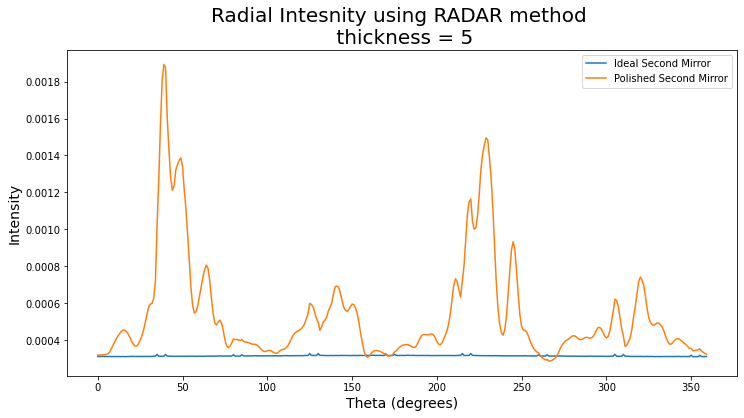

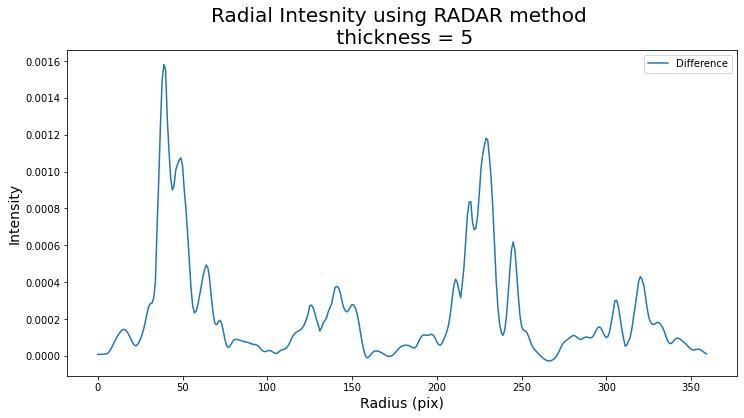

In [90]:
plt.figure(figsize = (12,6))

plt.plot(intensity_clean_radial2, label = 'Ideal Second Mirror')
plt.plot(intensity_dirty_radial2, label = 'Polished Second Mirror')
#plt.yscale('log')
plt.xlabel('Theta (degrees)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using RADAR method \n thickness = 5', fontsize = 20)
#plt.vlines(100, 0, 0.1, ls= '--', color = 'black')
plt.legend()

plt.figure(figsize = (12,6))

plt.plot(intensity_dirty_radial2 - intensity_clean_radial2, label = 'Difference')
#plt.vlines(100, 0, 0.01, ls= '--', color = 'black')
#plt.yscale('log')
plt.xlabel('Radius (pix)', fontsize = 14)
plt.ylabel('Intensity', fontsize = 14)
plt.title('Radial Intesnity using RADAR method \n thickness = 5', fontsize = 20)
plt.legend()